# Praca Domowa DL
1. [Zadanie 1](#Zadanie-1) ✓
2. [Zadanie 2](#Zadanie-2) ✓

## Wgranie Bibliotek

In [5]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 284.1/284.1 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 4.2 MB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 kB 4.0 MB/s eta 0:00:00
     -------------------------------------- 130.2/130.2 kB 7.5 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 2.3 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 2.8 MB/s eta 0:00:00
     -------------------------------------- 430.5/

In [1]:
# Podstawowe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md

# Do obróbki danych
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

# Do DL
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

#Zmienienie formatu zapisu danych numerycznych na dwie cyfry po przecinku.
pd.options.display.float_format = '{:.2f}'.format

## Zadanie 1

Zadanie 1. 25pkt 
Zadaniem jest określenie typów wina na podstawie poniższego zbioru danych: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

Przeprowadź krótką wstępną analizę danych
Stwórz funkcję budującą model (DNN)
Przeprowadź trening i walidację wyników
Na podstawie historii treningu przedstaw zmianę funkcji loss
Sprawdź jak zmiana parametrów i architektury Twojej sieci wpływa na wyniki i przedstaw swoje obserwacje

In [2]:
# Wczytanie i podgląd danych
from sklearn.datasets import load_wine
wine_data = load_wine()
print(wine_data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

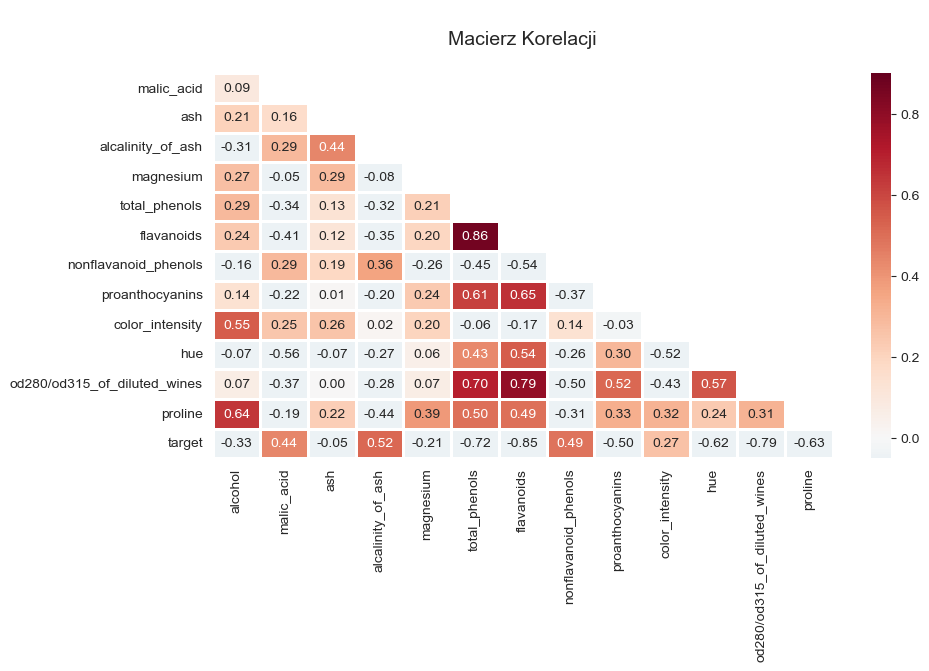

In [3]:
# Analiza danych

# Na podstawie opisu załączonego do zbioru danych, jesteśmy w stanie wyciągnąć dużo informacji. Przedewszystkim 
# zbiór składa się 178 rekordów podzielonych na 3 klasy w stosunku: class_0 (59), class_1 (71), class_2 (48). 
# Nie zawiera on brakujących danych, a tabela z średnią i odchyleniem standardowym nie wskazuje na dużą liczbę odstępstw.
# Przeprowadziłam również analizę korelacji pomiędzy zmiennymi, z której wynika że największa zależność istenieje pomiędzy
# kolumnami 'flavanoids' i 'total_phenols', co nie dziwi gdyż flawonoidy to polifenole. 

# Zmiana danych na DataFrame
wine_df = pd.DataFrame(data=np.c_[wine_data.data, wine_data.target], columns=wine_data.feature_names + ['target'])

# Wizualizacja korelacji za pomocą heatmapy
sns.set_style("white")
fig, ax = plt.subplots(figsize = (10, 5))   

mask = np.triu(np.ones_like(wine_df.corr(numeric_only = True), dtype = bool))[1:, :-1]
corr = wine_df.corr(numeric_only = True).iloc[1:,:-1].copy()

ax = sns.heatmap(corr, mask = mask, vmin = -0.05, vmax = 0.9, center = 0, annot = True, fmt = '.2f', 
                 cmap = 'RdBu_r', linewidths = 1, annot_kws = {"fontsize": 10})

ax.set_title('\nMacierz Korelacji\n', fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 10)
plt.show()

In [4]:
# Funkcja budująca model
def create_model_regression(name, in_num, h_num, h_act, out_num, drop, ):
    """
    in_num: ilość cech wejściowych (int)
    h_num: ilości neuronów w poszczególnych warstwach ukrytych (list)
    h_act: rodzaj aktywacji w warstwach ukrytych (str)
    out_num: ilość cech wyjściowych (int)
    drop: siła dropout'u (float)
    """
    
    model = tf.keras.Sequential(name = name)
    model.add(layers.InputLayer(input_shape = (in_num)))
    model.add(layers.BatchNormalization(input_shape = [in_num]))
    
    for idx, one_num in enumerate(h_num):
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(one_num, activation = h_act))
        model.add(layers.Dropout(drop))
        
    # warstwa wyjściowa
    model.add(layers.Dense(out_num, activation = 'softmax'))
    
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ['accuracy'])
    
    return model

In [5]:
# Podział danych na zbiór treningowy i testowy
X = wine_data.data
y = wine_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

# W celu zbadania jak zmiana parametrów i architektury sieci wpływa na wyniki, stworzyłam 4 przykładowe modele.

# Model 1 - 2 warstwy ukryte, learning rate = 0.5
model1 = create_model_regression('Model-1', X_train.shape[1], [32, 16], "relu", 3, 0.5)
history1 = model1.fit(X_train, y_train, batch_size = 10, epochs = 50, verbose = 0)

# Model 2 - 2 warstwy ukryte, learning rate = 0.001
model2 = create_model_regression('Model-2', X_train.shape[1], [32, 16], "relu", 3, 0.001)
history2 = model2.fit(X_train, y_train, batch_size = 10, epochs = 50, verbose = 0)

# Model 3 - 3 warstwy ukryte, learning rate = 0.001
model3 = create_model_regression('Model-3', X_train.shape[1], [64, 32, 16], "relu", 3, 0.001)
history3 = model3.fit(X_train, y_train, batch_size = 10, epochs = 50, verbose = 0)

# Model 4 - 4 warstwy ukryte, learning rate = 0.001
model4 = create_model_regression('Model-4', X_train.shape[1], [128, 64, 32, 16], "relu", 3, 0.001)
history4 = model4.fit(X_train, y_train, batch_size = 10, epochs = 50, verbose = 0)

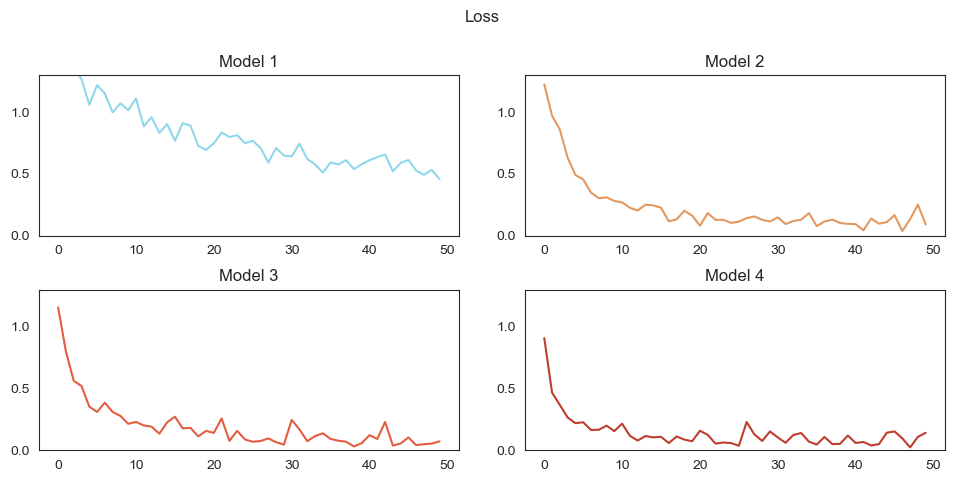

In [6]:
# Wykresy zmiany wartości metryki loss w trakcie uczenia modeli 

fig, axes = plt.subplots(2, 2, figsize = (10, 5))
fig.suptitle('Loss')
fig.tight_layout(pad = 2.0)

axes[0, 0].plot(history1.history["loss"], '#8fd8eb')
axes[0, 0].set_ylim([0, 1.3])
axes[0, 0].set_title("Model 1")

axes[0, 1].plot(history2.history["loss"], '#e3985f')
axes[0, 1].set_ylim([0, 1.3])
axes[0, 1].set_title("Model 2")

axes[1, 0].plot(history3.history["loss"], '#e35e40')
axes[1, 0].set_ylim([0, 1.3])
axes[1, 0].set_title("Model 3")

axes[1, 1].plot(history4.history["loss"], '#bd3d2f')
axes[1, 1].set_ylim([0, 1.3])
axes[1, 1].set_title("Model 4")

plt.show()

In [7]:
# Ocena jakości modeli

def model_eval(model, X_true, y_true):
    
    y_prob = model.predict(X_true, verbose = 0)
    y_pred = np.argmax(y_prob, axis = 1)
    
    metrics = [r2_score(y_true, y_pred),
               precision_score(y_true, y_pred, average = 'macro'), 
               recall_score(y_true, y_pred, average = 'macro'),
               f1_score(y_true, y_pred, average = 'macro'),
               roc_auc_score(y_true, y_prob, average = 'macro', multi_class = 'ovo')]
    
    return metrics

test_metrics = np.array([model_eval(model1, X_test, y_test), 
                         model_eval(model2, X_test, y_test),
                         model_eval(model3, X_test, y_test),
                         model_eval(model4, X_test, y_test)])

train_metrics = np.array([model_eval(model1, X_train, y_train), 
                          model_eval(model2, X_train, y_train),
                          model_eval(model3, X_train, y_train),
                          model_eval(model4, X_train, y_train)])

columns = ['Accuracy', 'Precison', 'Recall', 'F1 Score', 'AUC']
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

test_eval = pd.DataFrame(test_metrics, columns = columns, index = [models])
train_eval = pd.DataFrame(train_metrics, columns = columns, index = [models])

display(md("#### Metryki dla zbioru testowego"), test_eval)
display(md("#### Metryki dla zbioru treningowego"), train_eval)

#### Metryki dla zbioru testowego

,Accuracy,Precison,Recall,F1 Score,AUC
Model 1,0.83,0.90,0.92,0.91,1.00
Model 2,0.90,0.94,0.96,0.95,1.00
Model 3,0.95,0.97,0.98,0.97,1.00
Model 4,0.90,0.94,0.96,0.95,1.00


#### Metryki dla zbioru treningowego

,Accuracy,Precison,Recall,F1 Score,AUC
Model 1,0.95,0.97,0.97,0.97,1.00
Model 2,1.00,1.00,1.00,1.00,1.00
Model 3,1.00,1.00,1.00,1.00,1.00
Model 4,1.00,1.00,1.00,1.00,1.00


In [ ]:
# Obserwacje

# W przypadku Modelu 1 i 2 różniły się one jedynie wartością learning rate. Patrząc na wyniki dla zbioru testowego,
# Model 2 osiągnał wyższe wartości metryk. Oznacza to, że dla przyjętych batch_size = 10 i epochs = 50, 
# lr równy 0.001 okazał się lepszy.

# Następnie porównując modele 2, 3 i 4 sprawdziłam jak ilość warst ukrytych wpływa na jakość modeli. Porównując wyniki
# z obu tabel - dla zbioru testowego i treningowego najelszym okazał się model 3 (3 warstwy ukryte). Wartości metryk 
# dla modelu 4 na zbiorze testowym nie wzrosły, co może świadczyć o przeuczeniu dla wybranej liczby epok. 

## Zadanie 2

Zadanie 2. 25pkt 
Zapoznaj się z danymi: https://www.kaggle.com/datasets/weinoose/migraine-classification dotyczącymi klasyfikacji migreny (zmienna y= 'Type').
Dokonaj analizy zbioru oraz przekształć zmienną y na postać 0/1 według własnego podejścia.
Korzystając z klasy poznanej na zajęciach ("modelANN_ext") stwórz model sieci neuronowej. Wytypuj najlepszą Twoim zdaniem funkcję aktywacji. 
Zoptymalizuj parametry modelu: na początku learning rate, a później liczbę neuronów w wartswie ukrytej. 

In [8]:
data = pd.read_csv('data.csv')
data_df = pd.DataFrame(data)

display(md("#### Podgląd danych"), data_df.head(1))
display(md("#### Sprawdzenie braków"), data_df.isna().sum())
display(md("#### Wywołanie metody describe()"), data_df.describe())

#### Podgląd danych

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,...,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF,Type
0,30,1,5,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,0,Typical aura with migraine


#### Sprawdzenie braków

Age            0
Duration       0
Frequency      0
Location       0
Character      0
Intensity      0
Nausea         0
Vomit          0
Phonophobia    0
Photophobia    0
Visual         0
Sensory        0
Dysphasia      0
Dysarthria     0
Vertigo        0
Tinnitus       0
Hypoacusis     0
Diplopia       0
Defect         0
Ataxia         0
Conscience     0
Paresthesia    0
DPF            0
Type           0
dtype: int64

#### Wywołanie metody describe()

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,...,Dysarthria,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF
count,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.00,...,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.00
mean,31.70,1.61,2.37,0.97,0.98,2.47,0.99,0.32,0.98,0.98,...,0.00,0.12,0.06,0.01,0.01,0.01,0.00,0.02,0.01,0.41
std,12.14,0.77,1.68,0.27,0.28,0.77,0.11,0.47,0.15,0.14,...,0.05,0.33,0.24,0.12,0.07,0.12,0.00,0.13,0.09,0.49
min,15.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,22.00,1.00,1.00,1.00,1.00,2.00,1.00,0.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,28.00,1.00,2.00,1.00,1.00,3.00,1.00,0.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,40.00,2.00,4.00,1.00,1.00,3.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,77.00,3.00,8.00,2.00,2.00,3.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00


In [9]:
display(md("#### Liczebność klas w zbiorze"))
print(data_df['Type'].value_counts())

data_df['Binary Type'] = [0 if i in ['Typical aura without migraine', 'Other'] else 1 for i in data_df['Type']]
display(md("#### Liczebność klas po podziale"))
print(data_df['Binary Type'].value_counts())

#### Liczebność klas w zbiorze

Typical aura with migraine       247
Migraine without aura             60
Familial hemiplegic migraine      24
Typical aura without migraine     20
Basilar-type aura                 18
Other                             17
Sporadic hemiplegic migraine      14
Name: Type, dtype: int64


#### Liczebność klas po podziale

1    363
0     37
Name: Binary Type, dtype: int64


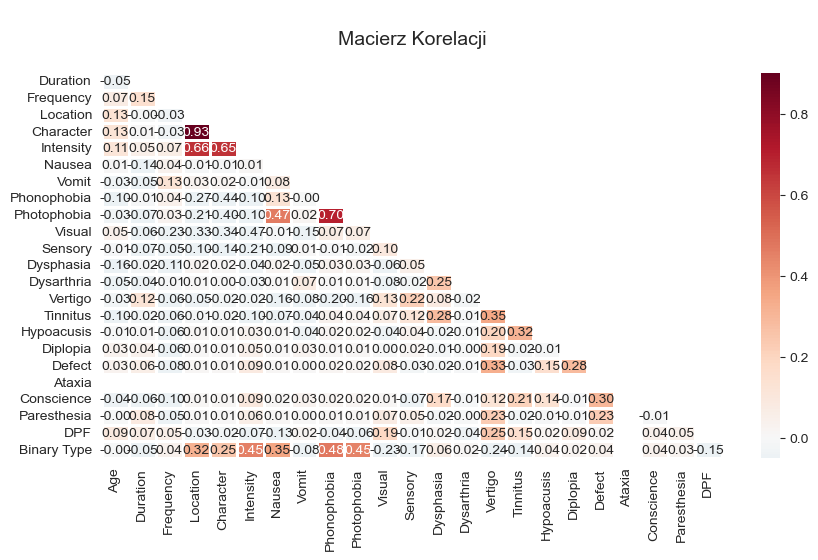

In [10]:
# Wizualizacja korelacji za pomocą heatmapy
sns.set_style("white")
fig, ax = plt.subplots(figsize = (10, 5))   

mask = np.triu(np.ones_like(data_df.corr(numeric_only = True), dtype = bool))[1:, :-1]
corr = data_df.corr(numeric_only = True).iloc[1:,:-1].copy()

ax = sns.heatmap(corr, mask = mask, vmin = -0.05, vmax = 0.9, center = 0, annot = True, fmt = '.2f', 
                 cmap = 'RdBu_r', linewidths = 1, annot_kws = {"fontsize": 10})

ax.set_title('\nMacierz Korelacji\n', fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 10)
plt.show()

In [11]:
# Usunięcie zbędnych kolumn ('Character' duża korelacja z Location, 'Ataxia' ma tylko wartości zerowe)
data_df = data_df.drop(['Character', 'Ataxia'], axis = 1)

# Przypisanie zbiórów
X = data_df.drop(['Type', 'Binary Type'], axis=1).astype('float32')
y = data_df['Binary Type'].astype('float32')

# Oversampling
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(y.value_counts())

# Podział na zbiór treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

1.00    363
0.00    363
Name: Binary Type, dtype: int64


In [12]:
# Definicja modelu jako klasy
class modelANN_ext(object):

    def __init__(self, hNum, hNum2, act_h, lr):
        """
        hNum: liczba neuronów w pierwszej ukrytej warstwie (int)
        hNum2: liczba neuronów w drugiej ukrytej warstwie (int)
        act_h: rodzaj aktywacji (str)
        lr: learning rate (float)
        """
        # inicjalizacja learnig rate'u
        self.lr = lr
        
        # ilość wejść
        self.inNum = 21
        # ilość wyjść
        self.outNum = 1
        
        # warstwa ukryta, 
        self.W_h = tf.Variable(tf.random.normal([self.inNum,hNum]))
        self.b_h = tf.Variable(tf.random.normal([hNum]))
        
        # druga warstwa ukryta, 
        self.W_h2 = tf.Variable(tf.random.normal([hNum,hNum2]))
        self.b_h2 = tf.Variable(tf.random.normal([hNum2]))
        
        # warstwa wyjściowa,
        self.W_out = tf.Variable(tf.random.normal([hNum2,self.outNum]))
        self.b_out = tf.Variable(tf.random.normal([self.outNum]))

        # aktywacja w warstwach ukrytych
        self.act_h = act_h
        
    def predict(self, x):
        """
        x: dane wejściowe 2D w formacie [batch, features]
        """
        # wejściowa warstwa
        layer_in = x
        
        # warstwa ukryta
        layer_hidden = tf.add(tf.matmul(layer_in, self.W_h), self.b_h)
        if self.act_h == "relu":
            layer_hidden = tf.nn.relu(layer_hidden)
        else:
            layer_hidden = tf.nn.sigmoid(layer_hidden)
            
        # warstwa ukryta
        layer_hidden2 = tf.add(tf.matmul(layer_hidden, self.W_h2), self.b_h2)
        if self.act_h == "relu":
            layer_hidden2 = tf.nn.relu(layer_hidden2)
        else:
            layer_hidden2 = tf.nn.sigmoid(layer_hidden2)
            
        # warstwa wyjściowa
        layer_out = tf.add(tf.matmul(layer_hidden2, self.W_out), self.b_out)
        layer_out = tf.nn.sigmoid(layer_out)
        
        return layer_out

    def weightsUpdate(self, dW_h, db_h, dW_h2, db_h2, dW_out, db_out):
        """
        dW_h:  hidden layer weights derivative
        db_h:  hidden layer bias derivative
        dW_out:  out layer weights derivative
        db_out:  out layer bias derivative
        """
        # korekta wag warstwy ukrytej
        self.W_h.assign_sub(self.lr * dW_h)
        # korekta biasu warstwy ukrytej
        self.b_h.assign_sub(self.lr * db_h)
        # korekta wag warstwy ukrytej
        self.W_h2.assign_sub(self.lr * dW_h2)
        # korekta biasu warstwy ukrytej
        self.b_h2.assign_sub(self.lr * db_h2)
        # korekta wag warstwy wyjściowej
        self.W_out.assign_sub(self.lr * dW_out)
        # korekta biasu warstwy wyjściowej
        self.b_out.assign_sub(self.lr * db_out)
    
    def lossMSE(self, y_pred, y_true):
        """
        y_pred: predykcja etykiet przez model
        y_true: prawdziwe wartości etykiet
        """
        # zmiana kztałtu referencji na potrzeby obliczeń macierzowych
        y_true = tf.reshape(y_true, (-1, self.outNum))
        
        return tf.reduce_mean(tf.square(y_pred - y_true))
    
    def fit(self, x, y_true):
        """
        x: dane treningowe
        y_true: prawdziwe wartości etykiet
        """
        # definicja taśmy
        with tf.GradientTape() as t:
            # wyznaczenie błędu
            current_loss = self.lossMSE(self.predict(x), y_true)
            
        # odwijamy taśmę i otrzymujemy pochodne
        dW_h, db_h, dW_h2, db_h2, dW_out, db_out = t.gradient(current_loss, [self.W_h, self.b_h, self.W_h2, self.b_h2,self.W_out, self.b_out])
        # korygowanie wag
        self.weightsUpdate(dW_h, db_h, dW_h2, db_h2, dW_out, db_out)
        
        return current_loss

In [13]:
# Definicja funkcji wyszukującej najlepsze parametry na podstawie accuracy
def myGridSearch(param_grid, act_h, epochsNum = 1000):
    '''
    Uproszczona wersja GridSearch, porównuje pary warstw dla 
    różnych wartości learnig_rate.
    
    param_grid: słownik hiperparametrów modelu, ważne
                aby hNum i hNum2 miały taką samą długość.
                 
    act_h: wybrany rodzaj aktywacji (str)

    '''
    r2_scores = []
    
    for i in range(len(params['hNum'])):
        for j in range(len(params['lr'])):
            
            model = modelANN_ext(param_grid['hNum'][i], 
                                 param_grid['hNum2'][i], 
                                 act_h, 
                                 param_grid['lr'][j])
        
            for k in range(epochsNum):
                model.fit(x_train, y_train).numpy()
            
            y_pred = model.predict(x_test).numpy().reshape(-1)
            r2_scores = np.append(r2_scores, r2_score(y_test, y_pred))
            
            if r2_scores[-1] > r2_scores[0]:
                best_hNum = i
                best_lr = j
            r2_scores[::-1].sort()
            
    print('Najlepsze parametry z acc={}% to: \n\t hNum: {}, hNum2: {}, act_h: {}, lr: {}\n'.format(round(r2_scores[0]*100, 2),
                                                                                                   param_grid['hNum'][best_hNum],
                                                                                                   param_grid['hNum2'][best_hNum],
                                                                                                   act_h,
                                                                                                   param_grid['lr'][best_lr]))

In [14]:
# Słownik parametrów do zbadania
params = {'hNum': [64, 128, 256, 512, 1024], 
          'hNum2': [32, 64, 128, 256, 512],  
          'lr': [0.5, 0.1, 0.05, 0.01, 0.001]}

myGridSearch(params, 'sigmoid')
myGridSearch(params, 'relu')

Najlepsze parametry z acc=89.5% to: 
	 hNum: 512, hNum2: 256, act_h: sigmoid, lr: 0.1

Najlepsze parametry z acc=-82.0% to: 
	 hNum: 64, hNum2: 32, act_h: relu, lr: 0.1



Accuracy: 91.12%
Precision: 97.56%
Recall: 97.56%
F1 Score: 97.56%
AUC: 97.78%


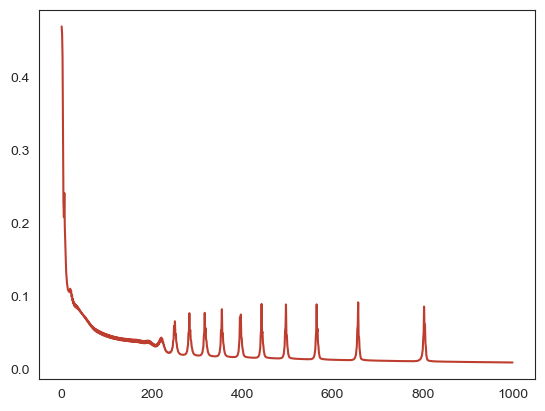

In [16]:
# Na podstawie prób i błędów najlepsze hiperparametry to hNum = 512, hNum2 = 256, lr = 0.1.
# Ponieważ zadaniem jest przeprowadzenie klasyfikacji binarnej, ReLu wydawało się lepszą funkcją aktywacyjną. Natomiast 
# wyniki wskazują przeciwnie, lepsze wartości model osiąga przy funkcji Sigmoid. 

# Jeszcze raz wyuczenie modelu na wytypowanych parametrach
myModel_ext = modelANN_ext(512, 256, 'sigmoid', 0.1)

lossList = []
epochsNum = 1000

for i in range(epochsNum):
    tmpLoss = myModel_ext.fit(x_train, y_train).numpy()
    lossList.append(tmpLoss)

# Przedstawienie zmiany metryki loss w trakcie uczenia modelu
plt.plot(np.arange(epochsNum), lossList, '#bd3d2f')

# Wyliczenie metryk
y_pred = np.rint(myModel_ext.predict(x_test).numpy().reshape(-1))

print('Accuracy: {}%'.format(round(r2_score(y_test, y_pred)*100, 2)))
print('Precision: {}%'.format(round(precision_score(y_test, y_pred)*100, 2)))
print('Recall: {}%'.format(round(recall_score(y_test, y_pred)*100, 2)))
print('F1 Score: {}%'.format(round(f1_score(y_test, y_pred)*100, 2)))
print('AUC: {}%'.format(round(roc_auc_score(y_test, y_pred)*100, 2)))